# ***Scandinavian News Articles***

This notebook is a part of the final project in ***Computational Tools for data science 02807*** and is written by *group 31* consisting of the members:

Felix Emil Bruun \
Eline Evje \
Malin Haugland Høli \
Ina Martini

Deadline: December 6, 2025

The main objective of the project is to analyze and compare political articles from various Scandinavian news outlets using machine learning, data mining techniques, and article classification.

## ***Imports***

In [264]:
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re
from datasketch import MinHashLSH, MinHash
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import seaborn as sns

## ***Import Dataset***

The datasets have been scraped using Selenium and BeautifulSoup.

In [265]:
news_articles = pd.read_csv('data/articles.csv')

# information about the dataset
news_articles.shape[0]
news_articles.info()
news_articles.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1192 non-null   object
 1   headline         1192 non-null   object
 2   content          1192 non-null   object
 3   url              1192 non-null   object
 4   source           1192 non-null   object
 5   country          1192 non-null   object
 6   worldview_score  1192 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 65.3+ KB


,date,headline,content,url,source,country,worldview_score
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3


## ***1. Preprocessing Steps***

### 1.1 Cleaning subscription boilerplate and layout noise

Many scraped news articles contain subscription prompts, “read more” links, and layout fragments that are not part of the actual content.

To avoid polluting the later similarity and clustering analyses, this has been removed from the `content` column. The resulting `content_clean` column is used for further text processing.

In [266]:
# 1) Define "boilerplate" markers you want to cut away and everything after
SUBSCRIPTION_MARKERS = [
    "Allerede abonnent? Log ind",
    "Allerede abonnent? Log ind her",
    "Log ind for at læse",
    "Log ind for at læse hele artiklen",
    "Log ind for at læse videre",
    "Logg inn for å lese",
    "Bli abonnent",
    "Tegn abonnement",
    "Få adgang til hele artiklen",
    "Få adgang til alt indhold",

    # Swedish / Norwegian / Danish "read more" prompts
    "Läs mer",       # SE
    "Læs mere",      # DK
    "Les mer",       # NO

    # DN print-view header
    "En utskrift från Dagens Nyheter",
]

def clean_content(text: str) -> str:
    if pd.isna(text):
        return ""
    t = str(text)

    # --- basic formatting fixes ---
    # remove leading "/ " like "/ Under 30 minuter ..."
    t = re.sub(r'^\s*/\s*', '', t)

    # remove bullet characters that often appear in scraped content
    t = t.replace("•", " ")

    # --- cut off subscription / boilerplate tail ---
    lower = t.lower()
    cut_pos = len(t)
    for marker in SUBSCRIPTION_MARKERS:
        idx = lower.find(marker.lower())
        if idx != -1 and idx < cut_pos:
            cut_pos = idx

    t = t[:cut_pos]

    # --- normalize whitespace ---
    t = re.sub(r'\s+', ' ', t).strip()

    return t

# Apply to your dataframe
news_articles['content_clean'] = news_articles['content'].apply(clean_content)

news_articles.head(5)

,date,headline,content,url,source,country,worldview_score,content_clean
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3,Under 30 minuter misshandlade de tre män och h...
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3,Det blir inga utbetalningar av matkuponger för...
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3,Under 30 minuter misshandlade de tre män och h...
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3,"Trump har både harceleret mod ""Forever Wars"" o..."
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3,Intentionen med loven er at forhindre sprednin...


### 1.2 Remove irrelevant links

In some norwegian articles posted by "vg.no" there are links to another website called "e24.no". These are not relevant for the project, and are therefore dropped from the data frame

In [267]:
# drop all norwegian articles from "vg" that contains "e24" in the url
e24_links = news_articles[(news_articles['country'] == 'norway') & (news_articles['source'] == 'vg') & (news_articles['url'].str.contains('https://e24.no'))]
news_articles = news_articles.drop(e24_links.index)
news_articles.reset_index(drop=True, inplace=True)

# print number of articles after preprocessing
print("Number of articles after preprocessing:", news_articles.shape[0])

Number of articles after preprocessing: 1184


### 1.3 Remove invalid source

During scraping the source "news" has been included, which is not a valid source. Rows with this source has also been dropped. 

In [268]:
# count rows with source "news"
invalid_source = news_articles[news_articles['source'] == 'news']
print("Number of articles with source 'news':", invalid_source.shape[0])

# drop rows with source "news"
news_articles = news_articles[news_articles['source'] != 'news']
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping 'news' source:", news_articles.shape[0])

Number of articles with source 'news': 9
Number of articles after dropping 'news' source: 1175


### 1.4 Standardize source names

Some sources have uppercase letters and some not, so we standardize by only using lowercase.

In [269]:
news_articles['source'] = news_articles['source'].str.lower()

### 1.5 Remove articles outside the intended time period 2020-2025

In [270]:
news_articles['date'] = pd.to_datetime(news_articles['date'], errors='coerce')
news_articles = news_articles[(news_articles['date'] >= '2020-01-01') & (news_articles['date'] <= '2025-12-31')]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after removing those outside 2020-2025:", news_articles.shape[0])

Number of articles after removing those outside 2020-2025: 1172


### 1.6 Remove duplicates

In [271]:
# 1. Drop strict duplicates (same URL + same content + same headline)
news_articles = news_articles.drop_duplicates(
    subset=['url', 'source', 'content_clean', 'headline']
).reset_index(drop=True)

print("After strict duplicates:", news_articles.shape[0])

# 2. Drop soft duplicates (same content/headline but different URL)
news_articles = news_articles.drop_duplicates(
    subset=['content_clean', 'headline']
).reset_index(drop=True)

print("After soft duplicates:", news_articles.shape[0])

After strict duplicates: 1090
After soft duplicates: 1042


### 1.7 Drop articles with worldview score 6, i.e., not classified

In [272]:
news_articles = news_articles[news_articles['worldview_score'] != 6]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping unclassified worldview score:", news_articles.shape[0])

Number of articles after dropping unclassified worldview score: 592


## ***2. Dataset Exploration***

### 2.1 Source information

The table below presents information about the *sources* (news outlets) that has been retrieved. There are 6 sources from Sweden, 5 from Denmark and 4 from Norway. The dataset for the analysis includes articles from 2020-2025. 

In [273]:
unique_sources = news_articles[['country', 'source']].drop_duplicates().sort_values(by='country')

sources_per_country = unique_sources['country'].value_counts()
display(HTML("<h4 style='font-weight:700'>Number of Sources per Country:</h4>"))
display(HTML("<pre style='font-family:monospace'>{}</pre>".format(
    sources_per_country.rename(index=lambda s: s.capitalize()).to_string(header=False)
)))

src_counts = (news_articles
              .groupby(['country', 'source'])
              .size()
              .reset_index(name='n_articles'))

# compute average worldview_score per country and source
temp_view = news_articles.copy()
temp_view['worldview_num'] = pd.to_numeric(temp_view['worldview_score'], errors='coerce')
avg_world = temp_view.groupby(['country', 'source'])['worldview_num'].mean().reset_index(name='avg_worldview').round(2)
display_df = src_counts.merge(avg_world, on=['country', 'source'], how='left')

# add column showing the time range of articles per country and source
time_ranges = (news_articles
                .groupby(['country', 'source'])
                .agg(first_article=('date', 'min'), last_article=('date', 'max'))
                .reset_index())

time_ranges['time_range'] = (
    time_ranges['first_article'].dt.strftime('%Y-%m-%d') +
    ' to ' +
    time_ranges['last_article'].dt.strftime('%Y-%m-%d')
)

display_df = display_df.merge(time_ranges[['country', 'source', 'time_range']], on=['country', 'source'])  
display_df = display_df[['source', 'n_articles', 'avg_worldview', 'country', 'time_range']]
display_df = display_df.sort_values(by='country').copy()
display(HTML(display_df.to_html(index=False, border=0)))

source,n_articles,avg_worldview,country,time_range
berlingske,96,2.32,denmark,2020-11-11 to 2025-10-29
dr,172,2.53,denmark,2020-11-15 to 2025-10-23
information,38,3.00,denmark,2020-12-04 to 2025-10-24
jyllands-posten,98,2.39,denmark,2020-11-19 to 2025-10-10
politiken,2,3.00,denmark,2021-12-02 to 2024-02-18
aftenposten,2,3.00,norway,2021-04-30 to 2024-08-24
dagbladet,2,4.00,norway,2020-11-08 to 2024-01-23
nrk,35,2.57,norway,2020-11-30 to 2025-06-28
vg,41,2.46,norway,2021-01-09 to 2025-11-05
aftonbladet,25,2.68,sweden,2021-03-30 to 2025-09-03


### 2.2 Article distribution per year in the different countries

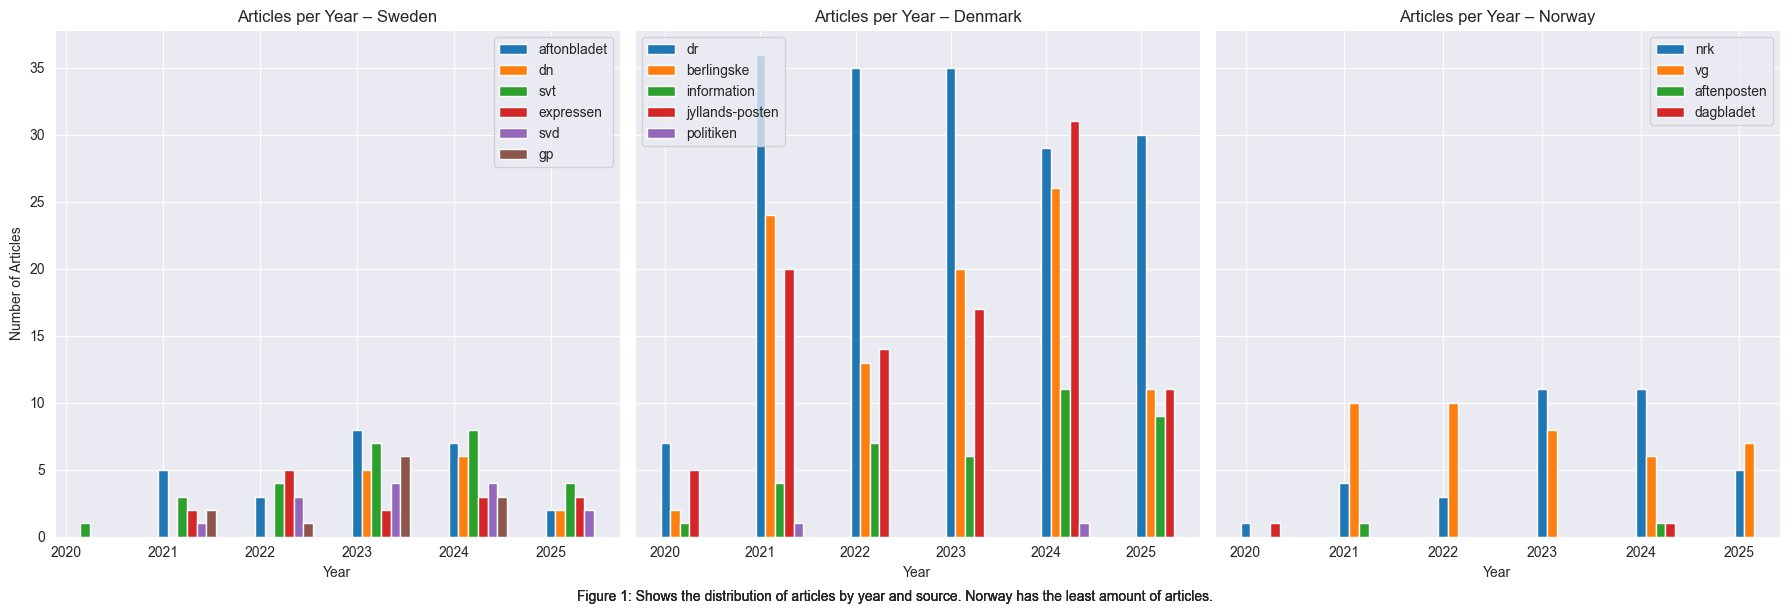

In [274]:
countries = news_articles['country'].unique()
num_countries = len(countries)

fig, axes = plt.subplots(1, num_countries, figsize=(18, 6), sharey=True)

if num_countries == 1:
    axes = [axes]

for ax, country in zip(axes, countries):
    country_data = news_articles[news_articles['country'] == country].copy()

    for i, source in enumerate(country_data['source'].unique()):
        source_data = country_data[country_data['source'] == source].copy()
        source_data['year'] = source_data['date'].dt.year
        year_counts = source_data['year'].value_counts().sort_index()

        ax.bar(
            year_counts.index + (0.1 * i),
            year_counts.values,
            width=0.1,
            label=source
        )

    ax.set_title(f'Articles per Year – {country.capitalize()}')
    ax.set_xlabel('Year')
    plt.figtext(0.5, -0.01, 'Figure 1: Shows the distribution of articles by year and source. Norway has the least amount of articles.', ha='center', fontsize=10)
    ax.set_xticks(range(2020, 2026))
    ax.legend()

axes[0].set_ylabel('Number of Articles')

plt.tight_layout()
plt.show()

### 2.3 Average worldview in each country from 2020-2025

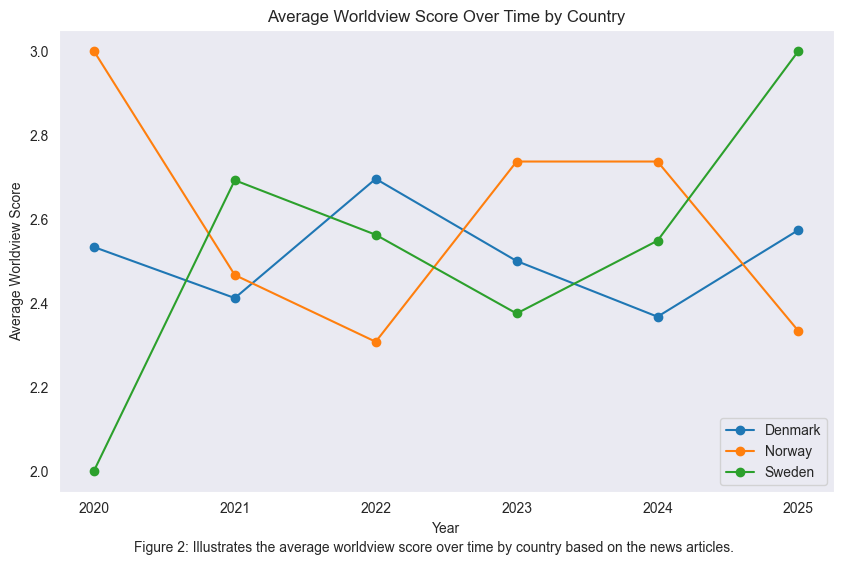

In [275]:
import matplotlib.pyplot as plt
worldview_over_time = (news_articles
                       .copy())
worldview_over_time['worldview_num'] = pd.to_numeric(worldview_over_time['worldview_score'], errors='coerce')
worldview_over_time['year'] = worldview_over_time['date'].dt.year
avg_worldview_time = (worldview_over_time
                      .groupby(['country', 'year'])['worldview_num']
                      .mean()
                      .reset_index())

plt.figure(figsize=(10, 6))
for country in avg_worldview_time['country'].unique():
    country_data = avg_worldview_time[avg_worldview_time['country'] == country]
    plt.plot(country_data['year'], country_data['worldview_num'], marker='o', label=country.capitalize())

    
plt.title('Average Worldview Score Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Average Worldview Score')
plt.figtext(0.5, 0.01, 'Figure 2: Illustrates the average worldview score over time by country based on the news articles.', ha='center', fontsize=10)
plt.xticks(avg_worldview_time['year'].unique())
plt.legend()
plt.grid()
plt.show()

## ***3. Data Analysis***

### 3.1 Implementing multilingual embeddings

Before comparing similarity methods (LSH, ANN, and clustering), a transformers model was used to map the different languages to a shared space. The result is is a embedding matrix that will be used for further analysis.

In [276]:
# Use headline + cleaned content for richer semantics
texts = (
    news_articles['headline'].fillna('') + ' ' +
    news_articles['content_clean'].fillna('')
).astype(str).tolist()

# Multilingual model that maps different languages to a shared space
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
embed_model = SentenceTransformer(model_name)

# Dense embedding matrix: shape (n_docs, embedding_dim)
emb_matrix = embed_model.encode(
    texts,
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=64  # tweak if GPU/CPU memory is small
)

print("Embedding matrix shape:", emb_matrix.shape)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Embedding matrix shape: (592, 384)


### 3.2 Approximate Nearest Neighbor (ANN)

The ANN uses a NearestNeighbors index over the multilingual embeddings vectors to quickly retrieve the articles most similar to a given one. 

In [277]:
def build_ann_index(matrix, n_neighbors=10, metric='cosine'):
    """
    Build an ANN index using scikit-learn's NearestNeighbors.
    Works with embeddings or any sparse matrix.
    """
    nn = NearestNeighbors(
        n_neighbors=n_neighbors + 1,  
        metric=metric,
        algorithm='brute'  # sparse matrices
    )
    nn.fit(matrix)
    return nn

# Build ANN index on embeddings
ann_index = build_ann_index(emb_matrix, n_neighbors=10)

def find_similar_articles(query_idx, ann_index, matrix, n_neighbors=10):
    """
    Find most similar articles to a given article using ANN.
    Returns indices and distances of similar articles.
    """
    query_vector = matrix[query_idx:query_idx+1]
    distances, indices = ann_index.kneighbors(query_vector)
    
    # Remove the query article itself (first result)
    return indices[0][1:], distances[0][1:]

In [278]:
def print_similar_articles(query_idx, ann_index, matrix, news_df, n):
    # Find ANN neighbors
    indices, distances = find_similar_articles(query_idx, ann_index, matrix, n_neighbors=n)

    # Build table
    rows = []
    news_df.loc[query_idx, 'country']

    for idx, dist in zip(indices, distances):
        rows.append({
            'similarity': round(1 - dist, 3),
            'country': news_df.loc[idx, 'country'],
            'source': news_df.loc[idx, 'source'],
            'headline': news_df.loc[idx, 'headline'],
            'clean_content': news_df.loc[idx, 'content_clean'],
            'worldview_score': news_df.loc[idx, 'worldview_score']
        })

    df = pd.DataFrame(rows)

    # Example using article 5 as query
    display(HTML(f"<h4 style='font-weight:700'>Example article {query_idx}:</h4>"))
    print(f"Headline: {news_df.loc[query_idx, 'headline']}")
    print(f"Country: {news_df.loc[query_idx, 'country']} | Source: {news_df.loc[query_idx, 'source']}")
    print(f"Worldview Score: {news_df.loc[query_idx, 'worldview_score']}\n")

    display(HTML("<h4 style='font-weight:700'>Most similar articles:</h4>"))
    display(df.head(n))

print_similar_articles(280, ann_index, emb_matrix, news_articles, n=10)

Headline: Trump dolker sin egen kandidat og stiller sig bag en gammel fjende
Country: denmark | Source: jyllands-posten
Worldview Score: 2



,similarity,country,source,headline,clean_content,worldview_score
0,0.728,denmark,berlingske,Mamdani sidder med nøglen til opgøret mod Trump,"Analyse: Det kan godt være, at valget i New Yo...",4
1,0.702,denmark,jyllands-posten,Trump truer med at begrænse New York-støtte fø...,Demokraternes kandidat fører meningsmålingerne...,2
2,0.699,sweden,expressen,Smällarna mot Trump – Demokraterna vinner vale...,Donald Trump har en tung valnatt. I New York v...,4
3,0.689,sweden,gp,Tre punkter: Därför pratar alla om ett borgmäs...,Gen Z älskar honom. Donald Trump och maktelite...,4
4,0.677,denmark,jyllands-posten,I New York kan Trump have kurs mod et nederlag...,Tirsdag kan en ung socialist sætte ild i det a...,2
5,0.674,denmark,information,New York får en socialistisk borgmester – og T...,"New York får en demokratisk socialist, inspire...",4
6,0.644,denmark,jyllands-posten,Ung socialist udråbt som ny borgmester i New York,Demokraten Zohran Mamdani har blandt andet gra...,4
7,0.631,norway,vg,Zohran Mamdani til VG: –⁠ Inspirert av Finland,Zohran Mamdani forsøker å bli borgermester i N...,4
8,0.631,sweden,expressen,”Galna kommunisten” – en present till Trump,Borgmästarvalet i New York ser ut att bli en p...,4
9,0.630,denmark,berlingske,Demokraterne sejrer stort i USA. Det er et pro...,Demokraterne vandt stort i USA i nat – og New ...,2


#### ANN analysis by country and worldview

This analysis checks how often each article’s most semantically similar neighbors come from the same country or share the same worldview score.

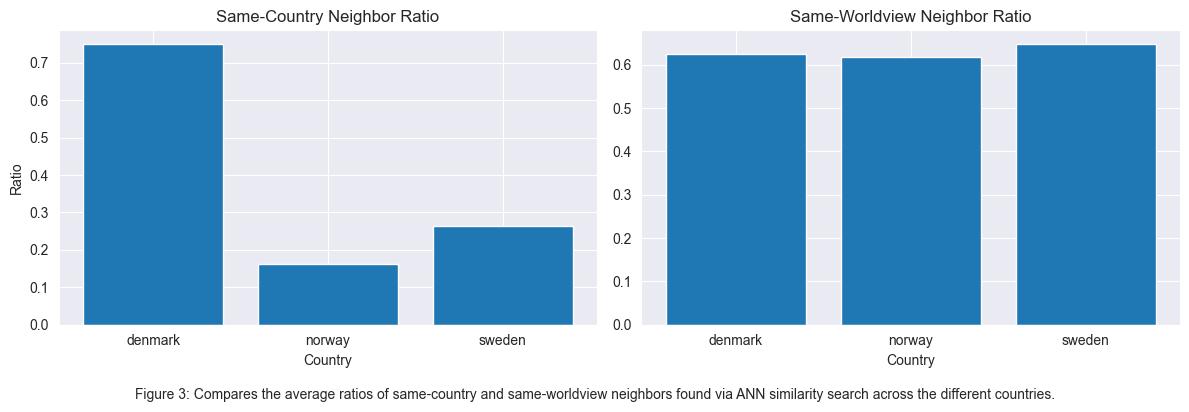

In [279]:
def analyze_similarities_by_country(ann_index, matrix, news_df, n_neighbors=10):
    """
    Analyze how similar articles cluster by country and worldview.
    """
    country_similarities = []
    worldview_similarities = []
    
    for i in range(len(news_df)):
        similar_indices, distances = find_similar_articles(i, ann_index, matrix, n_neighbors)
        
        query_country = news_df.loc[i, 'country']
        query_worldview = news_df.loc[i, 'worldview_score']
        
        # Count same-country neighbors
        same_country = sum(1 for idx in similar_indices 
                          if news_df.loc[idx, 'country'] == query_country)
        country_similarities.append(same_country / len(similar_indices))
        
        # Count same-worldview neighbors
        same_worldview = sum(1 for idx in similar_indices 
                           if news_df.loc[idx, 'worldview_score'] == query_worldview)
        worldview_similarities.append(same_worldview / len(similar_indices))
    
    return country_similarities, worldview_similarities

country_sim, worldview_sim = analyze_similarities_by_country(ann_index, emb_matrix, news_articles)

# Breakdown by country
country_breakdown = news_articles.copy()
country_breakdown['country_sim_ratio'] = country_sim
country_breakdown['worldview_sim_ratio'] = worldview_sim

country_stats = (country_breakdown
                .groupby('country')
                .agg({
                    'country_sim_ratio': 'mean',
                    'worldview_sim_ratio': 'mean'
                })
                .round(3))

country_stats_plot = country_stats.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# --- Left bar plot: Same-country ratio ---
axes[0].bar(country_stats_plot['country'], country_stats_plot['country_sim_ratio'])
axes[0].set_title("Same-Country Neighbor Ratio")
axes[0].set_xlabel("Country")
axes[0].set_ylabel("Ratio")

# --- Right bar plot: Same-worldview ratio ---
axes[1].bar(country_stats_plot['country'], country_stats_plot['worldview_sim_ratio'])
axes[1].set_title("Same-Worldview Neighbor Ratio")
axes[1].set_xlabel("Country")

plt.figtext(0.5, -0.01, 'Figure 3: Compares the average ratios of same-country and same-worldview neighbors found via ANN similarity search across the different countries.', ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

#### Measure ideological polarization within each media outlet
The polarization score reflects how semantically similar articles within a news outlet tend to share the same worldview rating, where higher values indicate stronger ideological alignment and lower values suggest greater ideological diversity within the outlet’s content.

In [280]:
def polarization(df, ann_index, matrix, group_col, n_neighbors=10):
    scores = []

    # Compute ANN worldview agreement score per article
    for i in range(len(df)):
        sim_idx, _ = find_similar_articles(i, ann_index, matrix, n_neighbors)
        target = df.loc[i, 'worldview_score']
        same = sum(df.loc[idx, 'worldview_score'] == target for idx in sim_idx)
        scores.append(same / len(sim_idx))

    df['polarization'] = scores

    # Group by chosen category (country, source, etc.)
    return (df.groupby(group_col)['polarization']
            .mean()
            .sort_values()
            .round(3))

pol_table = polarization(news_articles, ann_index, emb_matrix, group_col='source')
pol_table.to_frame(name='polarization')

,polarization
source,
dagbladet,0.250
aftenposten,0.450
politiken,0.500
aftonbladet,0.532
information,0.534
nrk,0.589
svt,0.600
dr,0.624
jyllands-posten,0.642


#### Semantic Ideological Consistency
The polarization score shows how semantically similar articles within a country tend to share the same worldview rating, where higher values indicate stronger ideological alignment.


In [281]:
pol_table = polarization(news_articles, ann_index, emb_matrix, group_col='country')
pol_table.to_frame(name='polarization')

,polarization
country,
norway,0.617
denmark,0.626
sweden,0.647


### 3.3 DBSCAN Clustering

Clustering can detect *groups of similar news articles* that emerge naturally from their content.

By clustering the articles and then inspecting the cluster contents, it is possible to e.g explore whether articles with similar ***worldview score*** appear in the same clusters. 

In [282]:
def perform_dbscan_clustering(matrix, eps=0.3, min_samples=5, metric='cosine'):
    """
    Perform DBSCAN clustering on the feature matrix.
    For cosine metric, we compute distances and use precomputed.
    """
    if metric == 'cosine':
        dense_matrix = matrix.toarray() if hasattr(matrix, 'toarray') else matrix
        distance_matrix = cosine_distances(dense_matrix)

        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='precomputed'
        )
        labels = dbscan.fit_predict(distance_matrix)
    else:
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric=metric
        )
        labels = dbscan.fit_predict(matrix.toarray() if hasattr(matrix, 'toarray') else matrix)

    return labels


def analyze_clusters(labels, news_df):
    """
    Analyze the clustering results.
    Returns cluster_df and cluster_count
    """
    cluster_df = news_df.copy()
    cluster_df['cluster'] = labels

    cluster_counts = pd.Series(labels).value_counts().sort_index()

    return cluster_df, cluster_counts

eps_values = [0.2, 0.3, 0.4, 0.5]
clustering_results = {}
for eps in eps_values:
    labels = perform_dbscan_clustering(emb_matrix, eps=eps, min_samples=3, metric='cosine')
    cluster_df, cluster_counts = analyze_clusters(labels, news_articles)
    clustering_results[eps] = (labels, cluster_df, cluster_counts)

#### Comparing different eps values

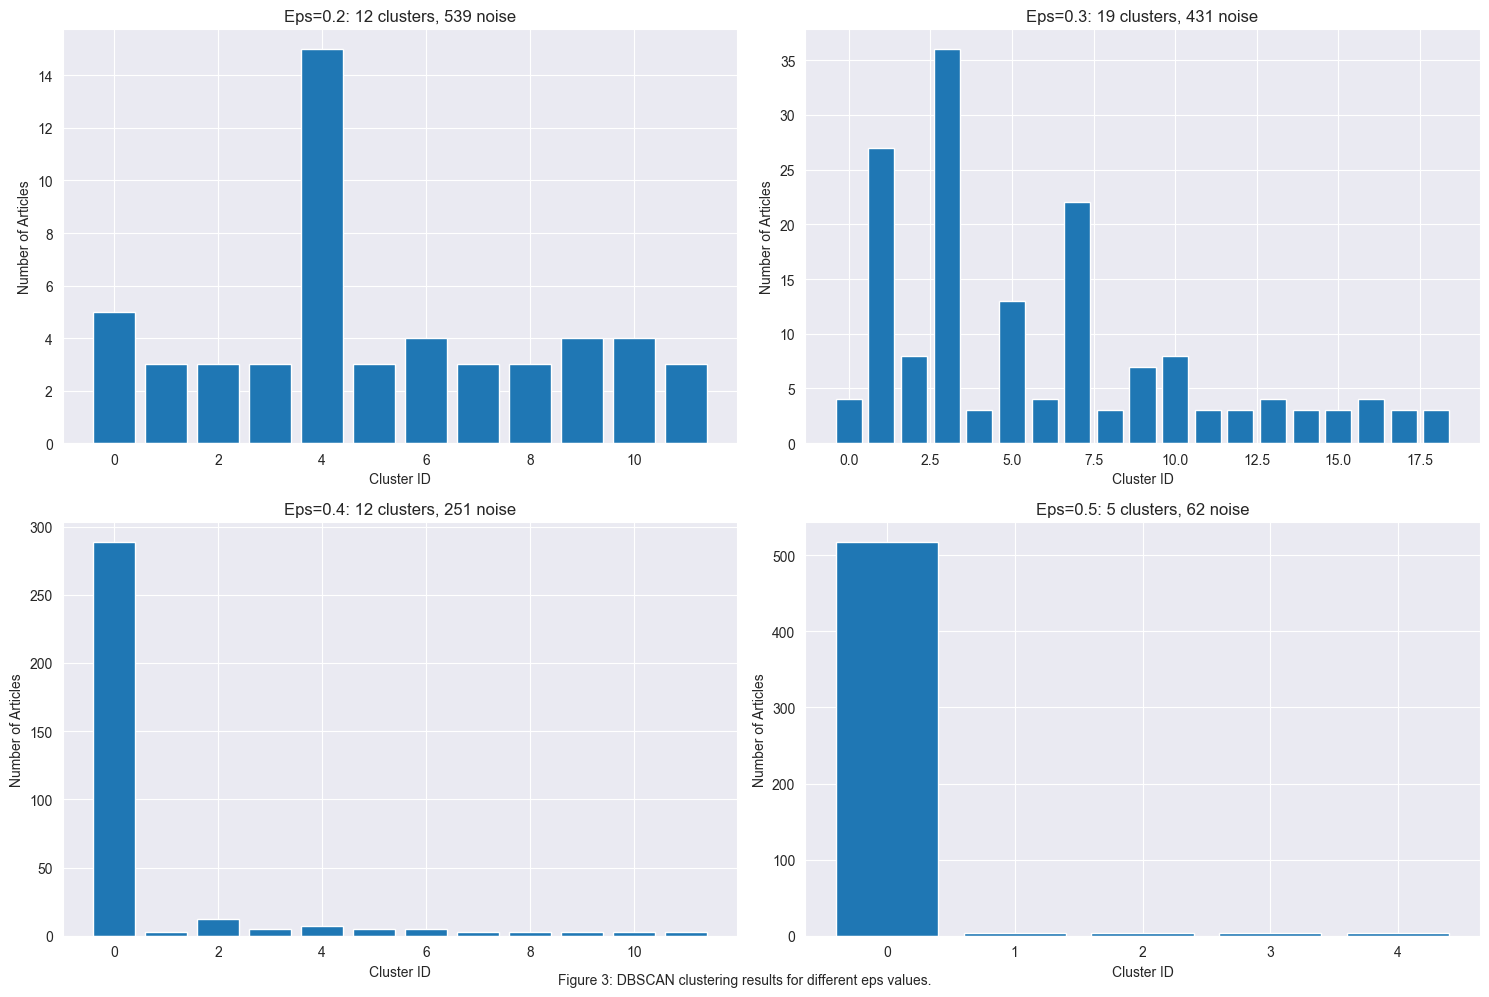

In [283]:
def visualize_eps_values(clustering_results):
    """
    Visualize DBSCAN clustering results for different eps values.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (eps, (labels, cluster_df, cluster_counts)) in enumerate(clustering_results.items()):
        ax = axes[i]
        
        # Plot cluster sizes (excluding noise)
        valid_clusters = cluster_counts[cluster_counts.index != -1]
        
        if len(valid_clusters) > 0:
            ax.bar(range(len(valid_clusters)), valid_clusters.values)
            ax.set_title(f'Eps={eps}: {len(valid_clusters)} clusters, {cluster_counts.get(-1, 0)} noise')
            ax.set_xlabel('Cluster ID')
            ax.set_ylabel('Number of Articles')
        else:
            ax.text(0.5, 0.5, f'No clusters found\n(eps={eps})', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Eps={eps}: No clusters')
    
    plt.tight_layout()
    plt.figtext(0.5, 0.01, 'Figure 3: DBSCAN clustering results for different eps values.', ha='center', fontsize=10)
    plt.show()

visualize_eps_values(clustering_results)

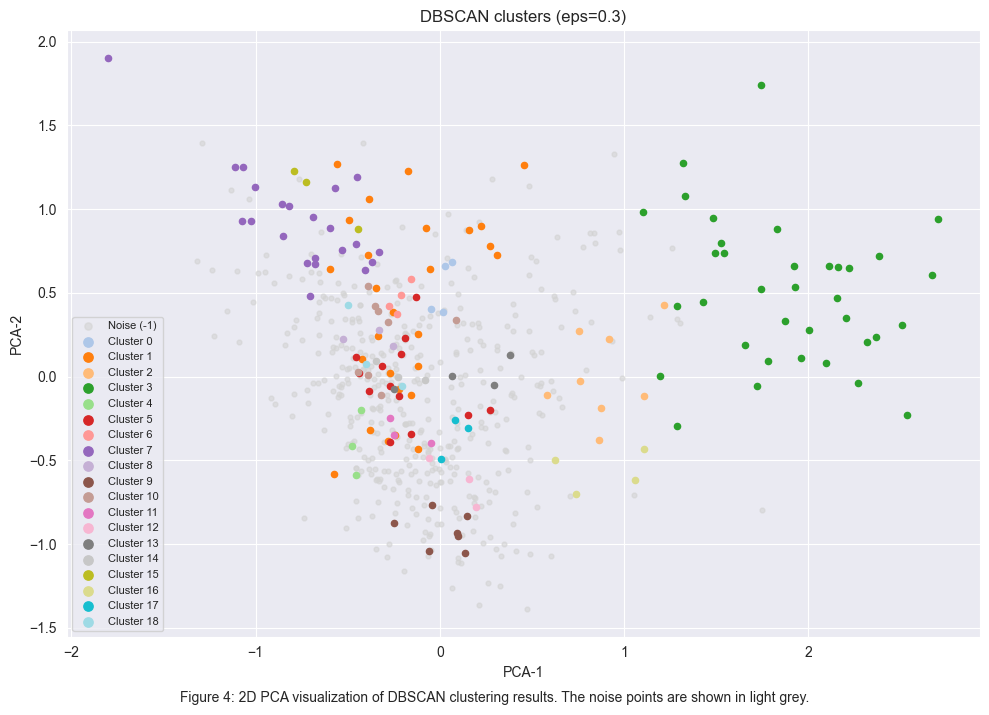

In [284]:
def visualize_clusters_2d_pca(emb_matrix, labels, title="Cluster Visualization (2D PCA)"):
    """
    Project embedding matrix to 2D using PCA and color points by cluster label.
    Noise points (-1) are shown in light grey.
    """
    # Ensure numpy array
    emb_matrix = np.asarray(emb_matrix, dtype=np.float32)

    # 2D PCA projection
    pca = PCA(n_components=2, random_state=42)
    emb_2d = pca.fit_transform(emb_matrix)

    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(10, 7))

    for lab, col in zip(unique_labels, colors):
        mask = (labels == lab)
        if lab == -1:
            plt.scatter(
                emb_2d[mask, 0], emb_2d[mask, 1],
                c="lightgrey", s=12, alpha=0.6, label="Noise (-1)"
            )
        else:
            plt.scatter(
                emb_2d[mask, 0], emb_2d[mask, 1],
                c=[col], s=20, label=f"Cluster {lab}"
            )

    plt.title(title)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.legend(loc="best", markerscale=1.5, fontsize=8)
    plt.tight_layout()
    plt.figtext(0.5, -0.01, 'Figure 4: 2D PCA visualization of DBSCAN clustering results. The noise points are shown in light grey.', ha='center', fontsize=10)
    plt.show()

eps = 0.3
labels, cluster_df, cluster_counts = clustering_results[eps]

visualize_clusters_2d_pca(
    emb_matrix,
    labels,
    title=f"DBSCAN clusters (eps={eps})"
)

#### Examine cluster content

This table provides a concise overview of each DBSCAN cluster by reporting its size, country/source composition, and worldview characteristics.

- n_articles – number of articles

- n_countries / main_country – country diversity and dominant country

- n_sources / main_source – source diversity and dominant source

- worldview_mean / worldview_std – average worldview and its variation

In [285]:
def summarize_clusters(cluster_df):
    """
    Create a summary table with basic stats for each cluster (excluding noise).
    """
    df = cluster_df.copy()
    df = df[df['cluster'] != -1]   # drop noise

    def dominant_value(s):
        vc = s.value_counts()
        if len(vc) == 0:
            return None
        top = vc.index[0]
        frac = vc.iloc[0] / vc.sum()
        return f"{top} ({frac:.2f})"

    summary = (df
        .groupby('cluster')
        .agg(
            n_articles=('cluster', 'size'),
            n_countries=('country', lambda x: x.nunique()),
            main_country=('country', dominant_value),
            n_sources=('source', lambda x: x.nunique()),
            main_source=('source', dominant_value),
            worldview_mean=('worldview_score', 'mean'),
            worldview_std=('worldview_score', 'std')
        )
        .sort_values('n_articles', ascending=False)
        .round({'worldview_mean': 3, 'worldview_std': 3})
    )

    return summary

best_eps = 0.3
_, best_cluster_df, best_cluster_counts = clustering_results[best_eps]

cluster_summary = summarize_clusters(best_cluster_df)
display(cluster_summary)


,n_articles,n_countries,main_country,n_sources,main_source,worldview_mean,worldview_std
cluster,,,,,,,
3,36,3,denmark (0.58),10,dr (0.22),3.139,1.046
1,27,3,denmark (0.78),7,berlingske (0.41),2.667,0.961
7,22,3,denmark (0.64),8,dr (0.50),3.273,0.985
5,13,2,denmark (0.92),4,jyllands-posten (0.54),2.462,0.877
2,8,3,denmark (0.62),6,jyllands-posten (0.25),2.000,0.000
10,8,2,denmark (0.75),5,svd (0.25),2.000,0.000
9,7,2,sweden (0.57),5,svt (0.29),2.000,0.000
16,4,2,denmark (0.75),2,dr (0.75),2.000,0.000
13,4,1,denmark (1.00),2,dr (0.75),2.500,1.000


#### Closer look at a cluster including all three countries

In [286]:
cluster_id = 3
cluster_3 = best_cluster_df[best_cluster_df['cluster'] == cluster_id].copy()

# Sample one example article per country
examples = (
    cluster_3
    .groupby('country')
    .head(2)          #
    .loc[:, ['country', 'source', 'headline', 'worldview_score', 'content_clean']]
)
display(examples)

,country,source,headline,worldview_score,content_clean
36,denmark,berlingske,Han har aldrig haft et rigtigt job. Nu kan han...,2,Kommentar: Det burde være en umulighed for den...
141,sweden,dn,Framgångsvåg för Demokraterna i hela USA,2,
168,sweden,gp,Britt-Marie Mattsson: Demokraterna och republi...,2,På tisdagen hålls flera val i USA. De blir ett...
226,denmark,information,Zohran Mamdanis politik er lige så idealistisk...,2,"I begyndelsen af sommeren, kort før det demokr..."
458,norway,vg,Mamdani har knekt koden,4,MeningerUnge meninger Mamdani kan bli New York...
464,norway,vg,Zohran Mamdani til VG: –⁠ Inspirert av Finland,4,Zohran Mamdani forsøker å bli borgermester i N...


### 3.4 Locality Sensitive Hashing

The LSH implementation below builds a *simple MinHash + LSH pipeline* as a baseline for detecting near-duplicate articles.

The main steps are:

1. MinHash signatures  
   Each article is represented by a MinHash object built from word shingles.  
   These signatures approximate the Jaccard similarity between articles.

2. MinHashLSH index 
   Each MinHash is inserted into a `MinHashLSH` index with a chosen similarity threshold.  
   This makes it possible to query similar articles without having to check all pairs. 

3. Enumerating similar pairs
   The implementation loops over all articles, queries the LSH index for neighbors, and collects all unique pairs of articles that LSH thinks are similar.

The headline and content is combined in order to capture the most meaning of an article. 

In [287]:
news_articles['combined'] = news_articles['headline'].fillna('') + ' ' + news_articles['content_clean'].fillna('')

def get_shingles(text, k=5):
    """
    Create word shingles (k-grams) from a text.
    Example: k=5 means sequences of 5 consecutive words.
    """
    # basic tokenization: keep alphanumeric words
    tokens = re.findall(r'\w+', str(text).lower())
    if len(tokens) < k:
        return set([' '.join(tokens)]) if tokens else set()
    return {
        ' '.join(tokens[i:i + k])
        for i in range(len(tokens) - k + 1)
    }

# Quick test on one article:
example_shingles = get_shingles(news_articles['combined'].iloc[3], k=5)
print("Number of shingles:", len(example_shingles)) 
print("The first 5 shingles:", list(example_shingles)[:5])

Number of shingles: 325
The first 5 shingles: ['også en mulighed for at', 'tale om sundhed eller anbefale', 'til diabetes og det vil', 'medtager eventuelle forbehold men udover', 'magt og får for meget']


In [288]:
def create_minhash(shingles, num_perm=128):
    """
    Build a MinHash signature from a set of shingles.
    num_perm controls the signature size (and accuracy).
    """
    m = MinHash(num_perm=num_perm)
    for sh in shingles:
        m.update(sh.encode('utf-8'))
    return m

num_perm = 128
k = 5  # shingle size

minhashes = {}

news_articles['text'] = news_articles['headline'].fillna('') + ' ' + news_articles['content_clean'].fillna('')

for idx, text in news_articles['text'].items():
    shingles = get_shingles(text, k=k)
    m = create_minhash(shingles, num_perm=num_perm)
    minhashes[idx] = m

print("Created MinHash signatures for", len(minhashes), "articles.")

Created MinHash signatures for 592 articles.


In [289]:
class EnhancedLSH:
    """
    LSH implementation with multiple hash families and analysis tools.
    """
    
    def __init__(self, threshold=0.5, num_perm=128, num_bands=None):
        self.threshold = threshold
        self.num_perm = num_perm
        self.num_bands = num_bands or max(1, num_perm // 8)
        self.lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
        self.minhashes = {}
        self.metadata = {}
        
    def add_document(self, doc_id, text, metadata=None):
        """
        Add a document to the LSH index.
        """
        shingles = get_shingles(text, k=5)
        minhash = create_minhash(shingles, self.num_perm)
        
        self.lsh.insert(str(doc_id), minhash)
        self.minhashes[doc_id] = minhash
        
        if metadata:
            self.metadata[doc_id] = metadata
    
    def query_similar(self, doc_id, return_scores=True):
        """
        Find similar documents to a given document.
        """
        if doc_id not in self.minhashes:
            return []
            
        query_hash = self.minhashes[doc_id]
        candidates = self.lsh.query(query_hash)
        
        results = []
        for candidate in candidates:
            candidate_id = int(candidate)
            if candidate_id == doc_id:
                continue
                
            if return_scores:
                similarity = query_hash.jaccard(self.minhashes[candidate_id])
                results.append((candidate_id, similarity))
            else:
                results.append(candidate_id)
        
        if return_scores:
            results.sort(key=lambda x: x[1], reverse=True)
            
        return results
    
    def get_all_similar_pairs(self):
        """
        Get all similar pairs found by LSH.
        """
        similar_pairs = set()
        
        for doc_id in self.minhashes:
            neighbors = self.query_similar(doc_id, return_scores=False)
            for neighbor_id in neighbors:
                pair = tuple(sorted((doc_id, neighbor_id)))
                similar_pairs.add(pair)
        
        return similar_pairs

# LSH index
enhanced_lsh = EnhancedLSH(threshold=0.3, num_perm=128)

for idx, row in news_articles.iterrows():
    metadata = {
        'country': row['country'],
        'source': row['source'],
        'worldview_score': row['worldview_score'],
        'headline': row['headline']
    }
    enhanced_lsh.add_document(idx, row['combined'], metadata)

print(f"LSH index built with {len(enhanced_lsh.minhashes)} documents")

LSH index built with 592 documents


#### LSH Performance

Given an `EnhancedLSH` instance, it:

1. Retrieves all similar article pairs that LSH has found.
2. Computes the true MinHash Jaccard similarity for each pair.
3. Tracks how often similar pairs share:
   - the same ***country***,
   - the same ***source***,
   - the same ***worldview score***.


Total similar article pairs detected by LSH: 17

**LSH Overlap Characteristics**
Avg Similarity: 0.396
Same Country Ratio: 1.0
Same Source Ratio: 0.588
Same Worldview Ratio: 0.824


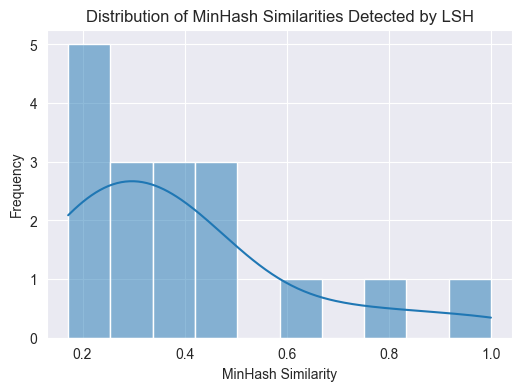

In [290]:
def analyze_lsh_performance(enhanced_lsh, news_articles, plot=True):
    """
    Analyze similarity patterns discovered by LSH and visualize reuse.
    """
    pairs = enhanced_lsh.get_all_similar_pairs()
    print(f"\nTotal similar article pairs detected by LSH: {len(pairs)}")

    similarities, same_country, same_source, same_worldview = [], 0, 0, 0

    for d1, d2 in pairs:
        sim = enhanced_lsh.minhashes[d1].jaccard(enhanced_lsh.minhashes[d2])
        similarities.append(sim)

        meta1, meta2 = enhanced_lsh.metadata[d1], enhanced_lsh.metadata[d2]
        same_country += (meta1['country'] == meta2['country'])
        same_source += (meta1['source'] == meta2['source'])
        same_worldview += (meta1['worldview_score'] == meta2['worldview_score'])

    metrics = {
        "avg_similarity": round(np.mean(similarities), 3) if similarities else 0,
        "same_country_ratio": round(same_country / len(pairs), 3) if pairs else 0,
        "same_source_ratio": round(same_source / len(pairs), 3) if pairs else 0,
        "same_worldview_ratio": round(same_worldview / len(pairs), 3) if pairs else 0
    }

    print("\n**LSH Overlap Characteristics**")
    for k, v in metrics.items():
        print(f"{k.replace('_', ' ').title()}: {v}")

    # Visualization of similarity scores
    if plot and similarities:
        plt.figure(figsize=(6,4))
        sns.histplot(similarities, bins=10, kde=True)
        plt.title("Distribution of MinHash Similarities Detected by LSH")
        plt.xlabel("MinHash Similarity")
        plt.ylabel("Frequency")
        plt.show()

    return metrics, pairs

metrics, similar_pairs = analyze_lsh_performance(enhanced_lsh, news_articles)


In [291]:
# Show top similar pairs
pair_details = []
for doc1, doc2 in list(similar_pairs)[:10]:
    sim = enhanced_lsh.minhashes[doc1].jaccard(enhanced_lsh.minhashes[doc2])
    pair_details.append((sim, doc1, doc2))

pair_details.sort(reverse=True)

print("\nTop 3 most similar pairs:")
for sim, doc1, doc2 in pair_details[:3]:
    print(f"\nSimilarity: {sim:.3f} | Pair: {doc1} – {doc2}")
    print(f"A: [{news_articles.loc[doc1, 'source']}] {news_articles.loc[doc1, 'headline']}"
          f"\nContent: {news_articles.loc[doc1, 'content_clean'][:100]} ...")
    print(f"B: [{news_articles.loc[doc2, 'source']}] {news_articles.loc[doc2, 'headline']}"
        f"\nContent: {news_articles.loc[doc2, 'content_clean'][:100]} ...")


Top 3 most similar pairs:

Similarity: 1.000 | Pair: 274 – 380
A: [jyllands-posten] AaB vil sikre likviditet til strategi med kapitaludvidelse
Content: Går det som AaB-bestyrelsen håber, rejser klubben 75 millioner kroner med en kapitaludvidelse i 2026 ...
B: [berlingske] AaB vil sikre likviditet til strategi med kapitaludvidelse
Content: Går det som AaB-bestyrelsen håber, rejser klubben 75 millioner kroner med en kapitaludvidelse i 2026 ...

Similarity: 0.805 | Pair: 67 – 74
A: [dr] Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
Content: Siden 2. maj har der været nye regler for udenlandske studerende på ikkestatsligt godkendte uddannel ...
B: [jyllands-posten] Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
Content: Siden den 2. maj har der været nye regler for udenlandske studerende på ikke-statsligt godkendte udd ...

Similarity: 0.398 | Pair: 159 – 188
A: [aftonbladet] Stor insats på Stegra – flera enheter på plats0:25
Co

To compare different LSH similarity thresholds, the LSH pipeline runs multiple times with varying `threshold` values.

The table reveals what threshold that balances: 
- *coverage* (not miss interesting similar articles),
- and *precision* (avoid flooding the analysis with weak matches).


In [292]:
def compare_lsh_thresholds(thresholds, news_df):
    """
    Compare LSH performance across different similarity thresholds.
    """
    results_summary = []

    for threshold in thresholds:
        lsh_test = EnhancedLSH(threshold=threshold, num_perm=128)

        for idx, row in news_df.iterrows():
            metadata = {
                'country': row['country'],
                'source': row['source'],
                'worldview_score': row['worldview_score']
            }
            lsh_test.add_document(idx, row['combined'], metadata)

        pairs = lsh_test.get_all_similar_pairs()

        if len(pairs) > 0:
            metrics, _ = analyze_lsh_performance(lsh_test, news_df, plot=False)
            avg_sim = metrics["avg_similarity"]
        else:
            avg_sim = 0

        results_summary.append({
            'threshold': threshold,
            'n_pairs': len(pairs),
            'avg_similarity': avg_sim
        })

    return pd.DataFrame(results_summary)


# Test different thresholds
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = compare_lsh_thresholds(thresholds, news_articles)

display(HTML("<h4>LSH Threshold Comparison</h4>"))
display(HTML(threshold_results.to_html(index=False)))


Total similar article pairs detected by LSH: 113

**LSH Overlap Characteristics**
Avg Similarity: 0.161
Same Country Ratio: 1.0
Same Source Ratio: 0.929
Same Worldview Ratio: 0.673

Total similar article pairs detected by LSH: 17

**LSH Overlap Characteristics**
Avg Similarity: 0.396
Same Country Ratio: 1.0
Same Source Ratio: 0.588
Same Worldview Ratio: 0.824

Total similar article pairs detected by LSH: 11

**LSH Overlap Characteristics**
Avg Similarity: 0.494
Same Country Ratio: 1.0
Same Source Ratio: 0.364
Same Worldview Ratio: 0.909

Total similar article pairs detected by LSH: 6

**LSH Overlap Characteristics**
Avg Similarity: 0.581
Same Country Ratio: 1.0
Same Source Ratio: 0.167
Same Worldview Ratio: 0.833

Total similar article pairs detected by LSH: 2

**LSH Overlap Characteristics**
Avg Similarity: 0.902
Same Country Ratio: 1.0
Same Source Ratio: 0.0
Same Worldview Ratio: 1.0

Total similar article pairs detected by LSH: 2

**LSH Overlap Characteristics**
Avg Similarity: 0.9

threshold,n_pairs,avg_similarity
0.2,113,0.161
0.3,17,0.396
0.4,11,0.494
0.5,6,0.581
0.6,2,0.902
0.7,2,0.902
